### Libraries import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from library.synthetic_control import SyntheticControl
from library.data_generator import generate_gaussian_process_data
from library.synthetic_did import SyntheticDIDModel

### Data generation

In [2]:
# N = 10    
# T = 30      
# T0 = 15     
# effect = 3.0 

# all_series = generate_gaussian_process_data(N=N, T=T, length_scale=2.0, seed=42)
# all_series[0, T0:] += effect

# df_list = []
# for unit_idx in range(N):
#     for time_idx in range(T):
#         y_val = all_series[unit_idx, time_idx]
#         treated_flag = (unit_idx == 0)  
#         after_treatment_flag = (time_idx >= T0)
#         df_list.append({
#             "unit": unit_idx,
#             "time": time_idx,
#             "y": y_val,
#             "treated": treated_flag,
#             "after_treatment": after_treatment_flag
#         })
# data = pd.DataFrame(df_list)

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Подавляем предупреждения ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

def generate_gaussian_process_data(N=10, T=100, length_scale=2.0, seed=42):
    np.random.seed(seed)
    
    # Создаем временную сетку
    time_grid = np.linspace(0, 10, T)
    
    # Инициализируем массив для хранения временных рядов
    all_series = np.zeros((N, T))
    
    # Создаем ядро для гауссовского процесса
    kernel = RBF(length_scale=length_scale)
    
    # Генерируем временные ряды для каждого юнита
    for i in range(N):
        gp = GaussianProcessRegressor(kernel=kernel, random_state=seed+i)
        # Создаем фиктивный обучающий набор (требуется для GP)
        X_train = time_grid.reshape(-1, 1)
        y_train = np.random.normal(0, 1, size=T)
        gp.fit(X_train, y_train)
        
        # Генерируем временной ряд
        all_series[i, :] = gp.predict(time_grid.reshape(-1, 1))
    
    return all_series

# Задаем параметры
N = 10        # Количество юнитов
T = 100       # Количество временных периодов
T0 = 50       # Время начала лечения
effect = -5.0 # Эффект лечения

# Генерируем данные
all_series = generate_gaussian_process_data(N=N, T=T, length_scale=2.0, seed=42)

# Добавляем эффект лечения для первого юнита
all_series[0, T0:] += effect

# Модифицируем контрольные юниты: прибавляем 2 ко всем наблюдениям
for i in range(1, N):
    all_series[i, :] += 2

# Создаем DataFrame для удобства анализа
df_list = []
for unit_idx in range(N):
    for time_idx in range(T):
        y_val = all_series[unit_idx, time_idx]
        treated_flag = (unit_idx == 0)  # Первый юнит лечится
        after_treatment_flag = (time_idx >= T0)
        df_list.append({
            "unit": unit_idx,
            "time": time_idx,
            "y": y_val,
            "treated": treated_flag,
            "after_treatment": after_treatment_flag
        })

data = pd.DataFrame(df_list)


### Synthetic control example

Реализуем следующую модель:

$$
\min_{\mathbf{w} \in \Delta_J} \left\| \mathbf{y}_{\text{pre}}^{\text{tr}} - \mathbf{Y}_{\text{pre}}^{\text{co}} \mathbf{w} \right\|_2^2,
$$
,где $\Delta_J$ обозначает $J$-мерное симплексное множество, то есть

$$\Delta_J = \left\{ \mathbf{w} \in \mathbb{R}^{J} \,\bigg|\, w_j \ge 0, \; \sum_{j=1}^{J} w_j = 1 \right\}
$$

SC ATT: -7.0203
Веса синтетического контроля:
Индекс: 1, Значение: 0.08114418920823649
Индекс: 2, Значение: 0.028683291910823014
Индекс: 4, Значение: 0.06732722607850979
Индекс: 5, Значение: 0.578691657508738
Индекс: 6, Значение: 0.11724048274405689
Индекс: 7, Значение: 0.12691315254963575


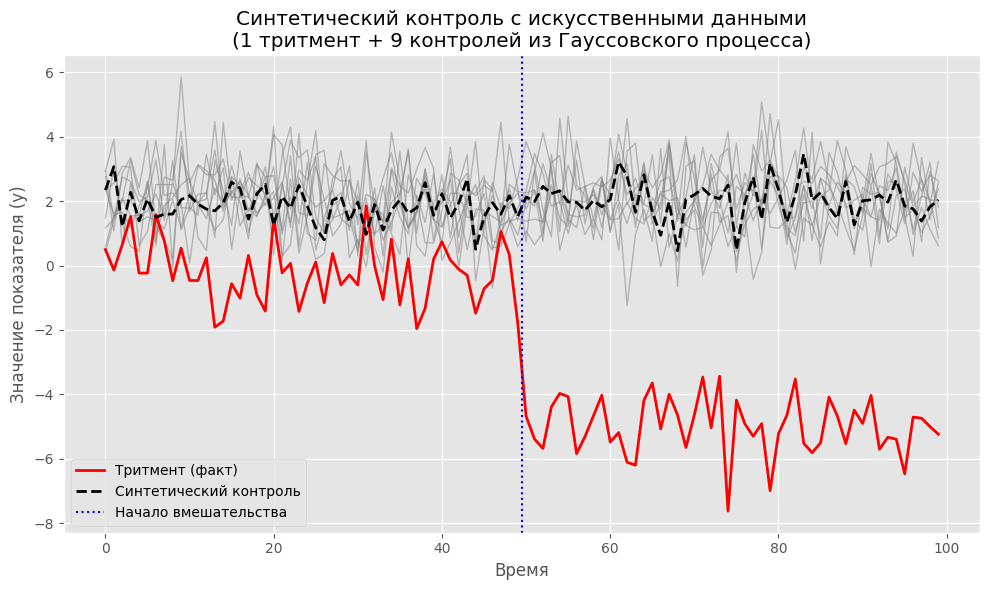

In [4]:
y_co_pre = (
    data.query("treated == False and after_treatment == False")
        .pivot(index="time", columns="unit", values="y")
)

y_tr_pre = (
    data.query("treated == True and after_treatment == False")
        .sort_values("time")["y"]
)

sc_model = SyntheticControl()
sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="weights")


y_co_all = (
    data.query("treated == False")
        .pivot(index="time", columns="unit", values="y")
        .sort_index()
)

sc_full = y_co_all.dot(sc_weights) 

y_tr_all = (
    data.query("treated == True")
        .sort_values("time")["y"]
    .reset_index(drop=True) 
)  

att = y_tr_all[T0:].mean() - sc_full[T0:].mean()
print("SC ATT:", round(att, 4))

print("Веса синтетического контроля:")
sc_weights_reset = sc_weights.reset_index()
for i in range(len(sc_weights_reset)):
    value = sc_weights_reset['weights'][i]
    if value > 0:
        print(f"Индекс: {sc_weights_reset['unit'][i]}, Значение: {value}")


plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 6))

controls_all = data.query("treated == False")
for unit_idx in controls_all["unit"].unique():
    subset = controls_all.query("unit == @unit_idx").sort_values("time")
    ax.plot(subset["time"], subset["y"], color="gray", alpha=0.5, linewidth=1)

treated_all = data.query("treated == True").sort_values("time")
ax.plot(treated_all["time"], treated_all["y"], color="red", label="Тритмент (факт)", linewidth=2)

ax.plot(sc_full.index, sc_full.values, color="black", linestyle="--",
        label="Синтетический контроль", linewidth=2)

ax.axvline(T0 - 0.5, color='blue', linestyle=':', label='Начало вмешательства')

ax.set_xlabel("Время")
ax.set_ylabel("Значение показателя (y)")
ax.set_title("Синтетический контроль с искусственными данными\n(1 тритмент + 9 контролей из Гауссовского процесса)")
ax.legend()
plt.tight_layout()
plt.show()

### Synthetic DIFF and DIFF example

In [5]:
import numpy as np
import pandas as pd
import cvxpy as cp
import statsmodels.formula.api as smf
from joblib import Parallel, delayed
from toolz import partial

class SyntheticDIDModel:
    def __init__(self, data, outcome_col, period_index_col, shopno_col, treat_col, post_col, seed=42):
        self.data = data.copy()
        self.outcome_col = outcome_col
        self.period_index_col = period_index_col
        self.shopno_col = shopno_col
        self.treat_col = treat_col
        self.post_col = post_col
        self.seed = seed

    def calculate_regularization(self, data):
        n_treated_post = data.query(f"{self.post_col}").query(f"{self.treat_col}").shape[0]

        first_diff_std = (data
                          .query(f"~{self.post_col}")
                          .query(f"~{self.treat_col}")
                          .sort_values(self.period_index_col)
                          .groupby(self.shopno_col)[self.outcome_col]
                          .diff()
                          .std())

        return n_treated_post ** (1 / 4) * first_diff_std

    def join_weights(self, data, unit_w, time_w):
        joined = (data
                  .set_index([self.period_index_col, self.shopno_col])
                  .join(time_w)
                  .join(unit_w)
                  .reset_index()
                  .fillna({
                      time_w.name: 1 / len(pd.unique(data.query(f"{self.post_col}")[self.period_index_col])),
                      unit_w.name: 1 / len(pd.unique(data.query(f"{self.treat_col}")[self.shopno_col]))
                  })
                  .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
                  .astype({self.treat_col: int, self.post_col: int}))
        return joined

    def fit_time_weights(self, data):
        control = data.query(f"~{self.treat_col}")
        y_pre = (control
                 .query(f"~{self.post_col}")
                 .pivot(index=self.period_index_col, columns=self.shopno_col, values=self.outcome_col))
        y_post_mean = (control
                       .query(f"{self.post_col}")
                       .groupby(self.shopno_col)[self.outcome_col]
                       .mean()
                       .values)
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)

        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w @ X - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)

        return pd.Series(w.value[1:], name="time_weights", index=y_pre.index)

    def fit_unit_weights(self, data):
        zeta = self.calculate_regularization(data)
        pre_data = data.query(f"~{self.post_col}")

        y_pre_control = (pre_data
                         .query(f"~{self.treat_col}")
                         .pivot(index=self.period_index_col, columns=self.shopno_col, values=self.outcome_col))

        y_pre_treat_mean = (pre_data
                            .query(f"{self.treat_col}")
                            .groupby(self.period_index_col)[self.outcome_col]
                            .mean())

        T_pre = y_pre_control.shape[0]
        X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1)

        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X @ w - y_pre_treat_mean.values) +
                                T_pre * zeta ** 2 * cp.sum_squares(w[1:]))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)

        return pd.Series(w.value[1:], name="unit_weights", index=y_pre_control.columns), w.value[0]

    def synthetic_diff_in_diff(self, data=None):
        if data is None:
            data = self.data

        unit_weights, intercept = self.fit_unit_weights(data)
        time_weights = self.fit_time_weights(data)

        did_data = self.join_weights(data, unit_weights, time_weights)

        formula = f"{self.outcome_col} ~ {self.post_col}*{self.treat_col}"
        did_model = smf.wls(formula, data=did_data, weights=did_data["weights"] + 1e-10).fit()

        return did_model.params[f"{self.post_col}:{self.treat_col}"], unit_weights, time_weights, did_model, intercept


In [6]:
sdid_model = SyntheticDIDModel(
    data=data,
    outcome_col="y",
    period_index_col="time",
    shopno_col="unit",
    treat_col="treated",
    post_col="after_treatment"
)

att, unit_weights, time_weights, sdid_model, intercept = sdid_model.synthetic_diff_in_diff()

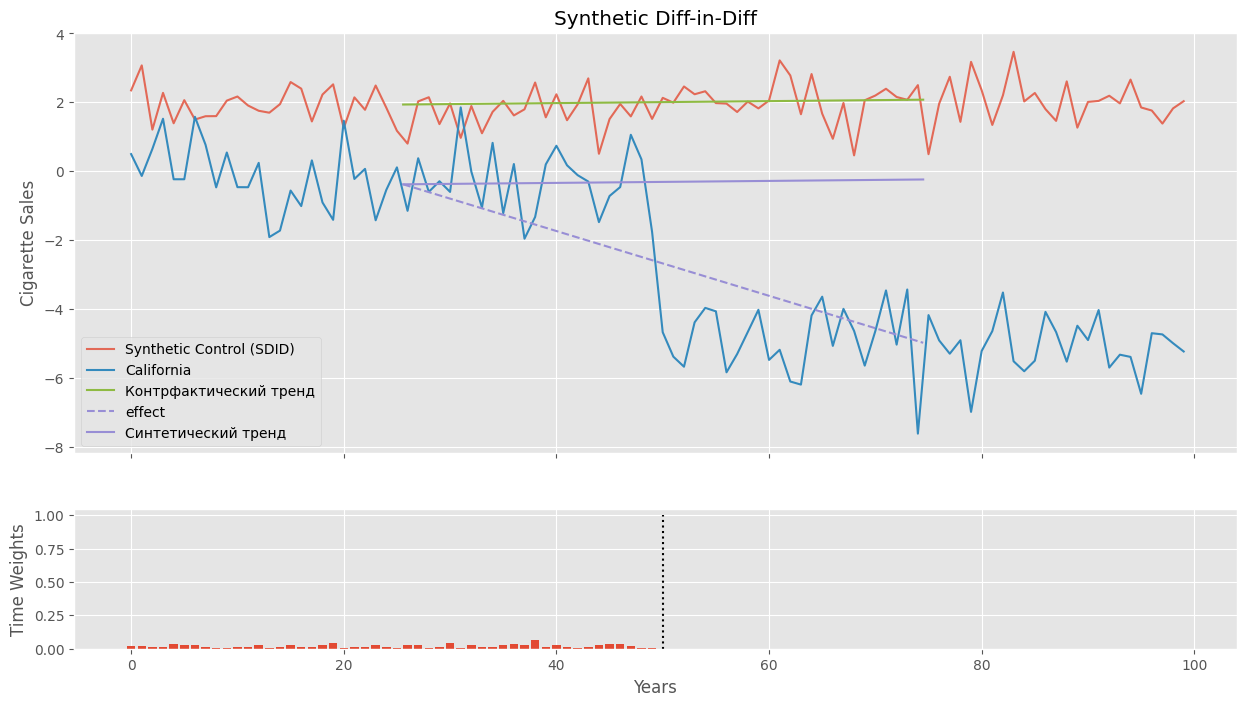

In [12]:
sc_did = y_co_all.dot(sc_weights) 
sdid_model = SyntheticDIDModel(
    data=data,
    outcome_col="y",
    period_index_col="time",
    shopno_col="unit",
    treat_col="treated",
    post_col="after_treatment"
)

att, unit_weights, time_weights, sdid_model_fit, intercept = sdid_model.synthetic_diff_in_diff()

# Вычисляем средний временной период до и после воздействия
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = T0 + (data.time.max() - T0) / 2

pre_sc = sdid_model_fit.params["Intercept"]
post_sc = pre_sc + sdid_model_fit.params["after_treatment"]
pre_treat = pre_sc + sdid_model_fit.params["treated"]
post_treat = post_sc + sdid_model_fit.params["treated"] + sdid_model_fit.params["after_treatment:treated"]
sc_did_y0 = pre_treat + (post_sc - pre_sc)

# Создаем график
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(sc_did.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=0.8)
ax1.plot(treated_all["time"], treated_all["y"], label="California", color="C1")

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc],
         color="C5", label='Контрфактический тренд')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat],
         color="C2", ls="dashed", label='effect')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0],
         color="C2", label='Синтетический тренд')

# Добавляем вертикальную скобку (с барьерами на концах) между значениями post_treat и sc_did_y0.
# Здесь x-координата скобки выбрана равной avg_post_period, а по оси y скобка тянется от нижней точки (sc_did_y0)
# до верхней (post_treat).
x_bracket = avg_post_period
y_top = post_treat      # предполагаем, что post_treat > sc_did_y0
y_bottom = sc_did_y0

# ax1.annotate(
#     '', 
#     xy=(x_bracket, y_bottom), 
#     xytext=(x_bracket, y_top),
#     arrowprops=dict(arrowstyle='|-|', color='purple', lw=2)
# )
# # Добавляем подпись "ATT". Смещаем её немного вправо от скобки (смещение по оси x можно подбирать по вкусу).
# ax1.text(x_bracket + 0.5, (y_top + y_bottom) / 2, f"ATT = {round(att,2)}",
#          color='purple', fontsize=12, va='center')

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(T0, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years")

plt.show()
